In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardcsv/creditcard.csv


In [2]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42
LABELS = ['Normal','Fraud']

In [3]:
df = pd.read_csv("/kaggle/input/creditcardcsv/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
columns = df.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"

state = np.random.RandomState(42)

X = df[columns]
y = df[target]

X_outliers = state.uniform(size=(X.shape[0],X.shape[1]))

print(X.shape, y.shape)

(284807, 30) (284807,)


# Exploratory Data Analysis

In [7]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

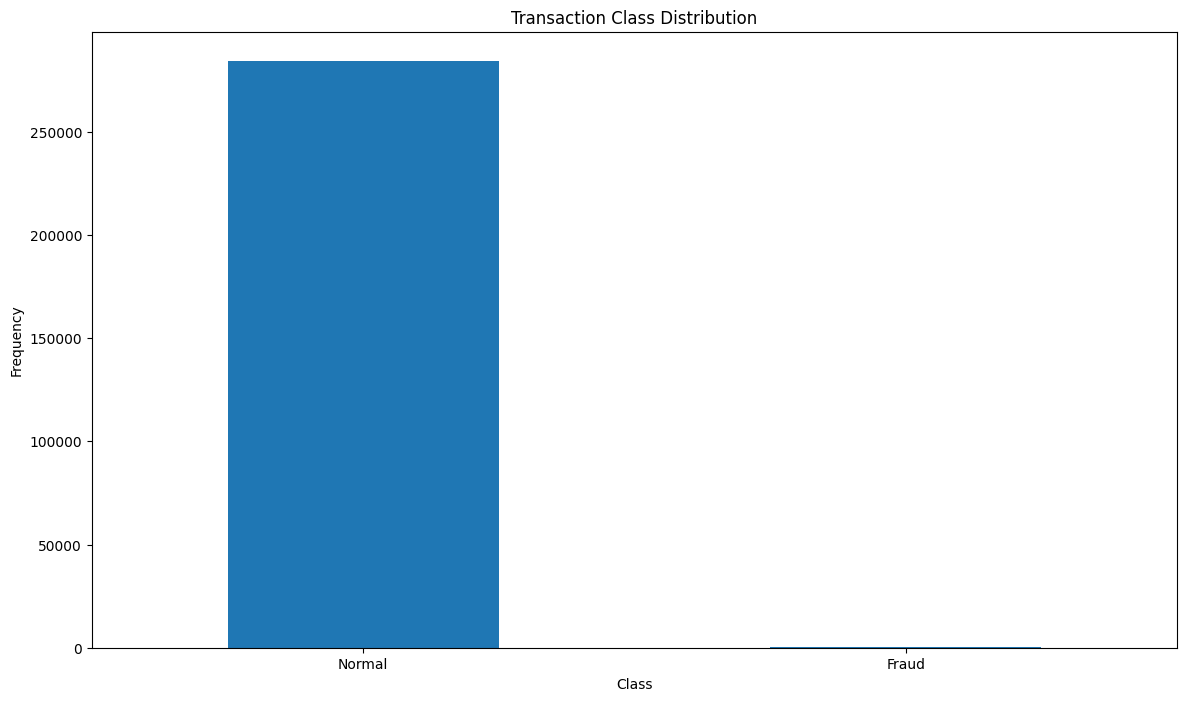

In [8]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot =0)

plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
# Get the fraud and normal dataset

fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [10]:
print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


# Under sampling using library nearmiss

In [11]:
from imblearn.under_sampling import NearMiss

In [12]:
nm = NearMiss()
X_res, y_res = nm.fit_resample(X, y)

In [13]:
X_res.shape, y_res.shape

((984, 30), (984,))

In [14]:
# Change in dataset after under sampling

from collections import Counter
print(f"Original dataset shape : {Counter(y)}")
print(f"Resampled dataset shape : {Counter(y_res)}")

Original dataset shape : Counter({0: 284315, 1: 492})
Resampled dataset shape : Counter({0: 492, 1: 492})


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
pred = knn.predict(X_test)

In [18]:
print(confusion_matrix(y_test, pred))

[[106   0]
 [ 12  79]]


In [19]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       106
           1       1.00      0.87      0.93        91

    accuracy                           0.94       197
   macro avg       0.95      0.93      0.94       197
weighted avg       0.95      0.94      0.94       197



# Over Sampling using SMOTETomek

In [20]:
# Get the fraud and normal dataset

fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [21]:
print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


In [22]:
# from imblearn.combine import SMOTETomek

In [23]:
# smk = SMOTETomek(random_state = 42)

In [24]:
# X_res, y_res = smk.fit_resample(X, y)

In [25]:
# X_res.shape, y_res.shape

In [26]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [27]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 5)
# knn.fit(X_train, y_train)

In [28]:
# pred = knn.predict(X_test)

In [29]:
# print(confusion_matrix(y_test, pred))

In [30]:
# print(classification_report(y_test, pred))

In [31]:
# Change in dataset after under sampling

# from collections import Counter
# print(f"Original dataset shape : {Counter(y)}")
# print(f"Resampled dataset shape : {Counter(y_res)}")

# Over Sampling using RandomOverSampler

In [32]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()

In [33]:
X_train_res, y_train_res = os.fit_resample(X, y)

In [34]:
X_train_res.shape, y_train_res.shape

((568630, 30), (568630,))

In [35]:
os_us = RandomOverSampler()

In [36]:
X_train_res1, y_train_res1 = os_us.fit_resample(X, y)

In [37]:
X_train_res1.shape, y_train_res1.shape

((568630, 30), (568630,))

In [38]:
# Change in dataset after under sampling

from collections import Counter
print(f"Original dataset shape : {Counter(y)}")
print(f"Resampled dataset shape : {Counter(y_train_res1)}")

Original dataset shape : Counter({0: 284315, 1: 492})
Resampled dataset shape : Counter({0: 284315, 1: 284315})


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_res1, y_train_res1, test_size = 0.2)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
pred = knn.predict(X_test)

In [42]:
print(confusion_matrix(y_test, pred))

[[56609   109]
 [    0 57008]]


In [43]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56718
           1       1.00      1.00      1.00     57008

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

